In [2]:
import torch
import torch.nn as nn
import csv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
list_of_strings = []
list_of_labels  = []

with open("data/EcoPreprocessed.csv") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        list_of_strings.append(row[1])
        list_of_labels.append(float(row[2]))
print(list_of_strings)
print(list_of_labels)

['able play youtube alexa', 'able recognize indian accent really well drop function helpful call device talk person near device smart plug schedule work seamlessly con would sound kindloud but lack clarity mid frequency need tweeked optimum clarity rarely device doesnt respond call alexa', 'absolute smart device amazon connect external sub woofer sound amaze recons voice even close room like almost collection songs english hindi must quite moneys worth', 'absolutely amaze new member family control home voice connect home anywhere world', 'absolutely amaze previously sceptical invest money but arrive worth ityou absolutely buy wont regret cheer', 'absolutely cheat customer if buy amazon product definitely want buy amazon prime members also case if song want play absolutely need amazon prime membership otherwise can not play music app no google apps not work amazon alexa if anybody want amazon alexa go google home everything also free cost app', 'absolutely house hold item fair price int

In [4]:
def get_dataset(list_of_strings):

    # First let's get the total set of words
    words = set()
    for sentence in list_of_strings:
        for word in sentence.split():
            words.add(word)

    vocab_size = len(words)

    # Now let's build a mapping
    sorted_list = sorted(list(words))
    word_to_int = {}
    for i, c in enumerate(sorted_list):
        word_to_int[c] = i + 1

    # Write encode() which is used to build the dataset

    def encode(sentence):
        integers = []
        for word in sentence.split():
            integers.append(word_to_int[word])
        return integers

    var_len_tensors = []
    for sentence in list_of_strings:
        var_len_tensors.append(torch.tensor(encode(sentence)))

    return vocab_size + 1, nn.utils.rnn.pad_sequence(var_len_tensors, batch_first = True), word_to_int

In [7]:
vocab_size, training_dataset, word_to_int = get_dataset(list_of_strings)
training_dataset

tensor([[  10, 3374, 5147,  ...,    0,    0,    0],
        [  10, 3734, 2256,  ...,    0,    0,    0],
        [  17, 4158, 1215,  ...,    0,    0,    0],
        ...,
        [5147, 4444, 3003,  ...,    0,    0,    0],
        [5152, 3582, 5030,  ...,    0,    0,    0],
        [5154, 2315,  767,  ...,    0,    0,    0]])

In [8]:
training_labels = torch.unsqueeze(torch.tensor(list_of_labels), dim = -1)
training_labels

tensor([[ 0.5000],
        [ 0.2794],
        [ 0.1827],
        ...,
        [ 0.0000],
        [ 0.0000],
        [-0.3125]])

In [12]:
class EmotionPredictor(nn.Module):
    def __init__(self, vocabulary_size: int, embedding_dimension: int):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocabulary_size, embedding_dimension)
        self.linear_layer = nn.Linear(embedding_dimension, 1)
        self.tanh = nn.Tanh()
    def forward(self, x):
        embeddings = self.embedding_layer(x)
        averaged = torch.mean(embeddings, axis = 1)
        projected = self.linear_layer(averaged)
        return self.tanh(projected)

In [13]:
embedding_dimension = 256
model = EmotionPredictor(vocab_size, embedding_dimension)

loss_f = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
for i in range(1000):
    randperm = torch.randperm(len(training_dataset))
    training_dataset, training_labels = training_dataset[randperm], training_labels[randperm]
    mini_batch = training_dataset[:64]
    mini_batch_labels = training_labels[:64]
    pred = model(mini_batch)
    optimizer.zero_grad()
    loss = loss_f(pred, mini_batch_labels)
    if i % 100 == 0:
        print(loss.item())
    loss.backward()
    optimizer.step()

0.23102562129497528
0.09669644385576248
0.17462095618247986
0.13363207876682281
0.13659828901290894
0.11896403133869171
0.1292305737733841
0.13259069621562958
0.09565925598144531
0.08098243921995163


In [14]:
example_one = "worst movie ever"
example_two = "best movie ever"
example_three = "weird but funny movie"
examples = [example_one] + [example_two] + [example_three]

var_len = []
for example in examples:
    ini_version = []
    for word in example.split():
        ini_version.append(word_to_int[word])
    var_len.append(torch.tensor(ini_version))

testing_tensor = torch.nn.utils.rnn.pad_sequence(var_len, batch_first=True)
model.eval()
print(model(testing_tensor).tolist())



[[-0.9999927878379822], [0.9878851175308228], [0.0954330563545227]]


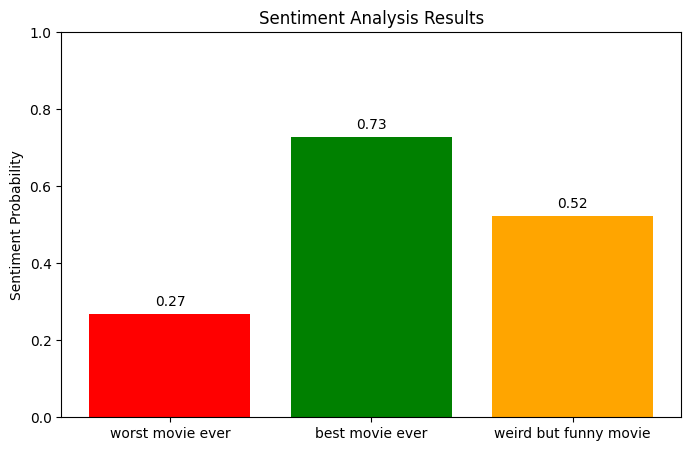

In [17]:
import matplotlib.pyplot as plt

# Sentences
sentences = ["worst movie ever", "best movie ever", "weird but funny movie"]

# Raw model outputs
raw_scores = torch.tensor([[-0.99999], [0.98788], [0.09543]])

# Convert to probabilities using sigmoid
probs = torch.sigmoid(raw_scores).squeeze().tolist()

# Assign colors based on sentiment score
colors = []
for p in probs:
    if p < 0.4:
        colors.append("red")      # Negative
    elif p > 0.6:
        colors.append("green")    # Positive
    else:
        colors.append("orange")   # Neutral

# Create bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(sentences, probs, color=colors)
plt.ylim(0, 1)
plt.ylabel("Sentiment Probability")
plt.title("Sentiment Analysis Results")

# Add probability labels on top of bars
for bar, prob in zip(bars, probs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.02,
             f"{prob:.2f}", ha="center", fontsize=10)

plt.show()